In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 6.8MB/s 


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the BERT tokenizer to break the text down into tokens and chunks that the model will recognize.

In [ ]:
# # Upload the train file from your local drive
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# df1 = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# DATASET_PATH  = '/content/gdrive/My Drive/training_tweets.csv'
df = pd.read_csv('/content/training_tweets.csv',  encoding='latin-1')
df.columns = ['label','id','date','device','user','sentence']

df = df.replace(4, 1)
dfzero = (df[df['label'] == 0])
dfzero = dfzero.sample(50000)
dfone = (df[df['label'] == 1])
dfone = dfone.sample(50000)
df = pd.concat([dfzero, dfone])

In [ ]:
df.sample(10)

,label,id,date,device,user,sentence
1043451,1,1957324017,Fri May 29 00:09:32 PDT 2009,NO_QUERY,BrittanyUrbina,@DodgersMLB Great Victory Today!
690215,0,2251960304,Sat Jun 20 05:04:38 PDT 2009,NO_QUERY,astilarasati,"in an incestuous relationship (eww), uh not li..."
174457,0,1964542474,Fri May 29 14:24:11 PDT 2009,NO_QUERY,Xemion,@savagemic @MailChimp hired all the smart monk...
139535,0,1880829705,Fri May 22 02:39:18 PDT 2009,NO_QUERY,matoakley,Problems with my #Android #G1. Can't access An...
1116673,1,1973280365,Sat May 30 10:50:35 PDT 2009,NO_QUERY,SexyNinjaMonkey,"@HappySinger Second, Melbourne is gay. You sho..."
1525726,1,2176913498,Mon Jun 15 05:02:40 PDT 2009,NO_QUERY,vonhoukenstien,Time to go to work
334884,0,2013669950,Tue Jun 02 23:15:38 PDT 2009,NO_QUERY,briiiiipolden,"@teiren474 bullshit. ouch, that hurt nathan"
1415070,1,2057153322,Sat Jun 06 12:28:21 PDT 2009,NO_QUERY,nandasalles,"Hey, tweets.. Here I am, back from a small tri..."
1130348,1,1975678788,Sat May 30 15:40:07 PDT 2009,NO_QUERY,1indienation,@GuyKawasaki sounds boring
262705,0,1986298126,Sun May 31 18:38:04 PDT 2009,NO_QUERY,anm_jb1,@ddlovato She lost. tears


In [ ]:
# Create sentence and label lists. USE SEP AND CLS to signify beginning and end
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
# Tokenize the statements
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '@', 'pink', '##dust', '##0', '##7', 'ha', 'that', "'", 's', 'janet', "'", 's', 'hero', 'ha', '##ha', '.', 'mary', '-', 'kate', "'", 's', 'is', 'better', 'except', 'for', 'the', 'fur', '[SEP]']


In [ ]:
# Convert tokens and pad sequence
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Train test split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Torch conversion
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. Create an iterator of our data with torch DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
# Load BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
# Experimenting with Freezing Layers 
#freezing layers
# for i,layer in enumerate(model.children()):
#   print(i)
#   for j,sublayer in enumerate(layer.children()):
#     if(i == 0 and j== 0):
#       #if you are int he first sub layer, we are going to freeze everything
#       for param in sublayer.parameters():
#         param.requires_grad = False
#       break



#     for k,subsublayer in enumerate(sublayer.children()):
#       print('   ',k)
#       for l,subsubsublayer in enumerate(subsublayer.children()):
#         #print('     ',l, dict(subsubsublayer.named_parameters()).keys())
#         #Freeze 0-10 BERT layers
#         if(i == 0 and j== 1 and k == 0 and l< 11):
#           for param in subsubsublayer.parameters():
#             param.requires_grad = False
    

0
1
2


In [ ]:
# Set and optimize parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Model training
t = [] 
train_loss_set = []
epochs = 3
for _ in trange(epochs, desc="Epoch"):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.40836194989416336


Epoch:  33%|███▎      | 1/3 [09:35<19:11, 575.82s/it]

Validation Accuracy: 0.836
Train loss: 0.254350206123458


Epoch:  67%|██████▋   | 2/3 [19:12<09:36, 576.11s/it]

Validation Accuracy: 0.843
Train loss: 0.12438440319399038


Epoch: 100%|██████████| 3/3 [28:49<00:00, 576.36s/it]

Validation Accuracy: 0.831


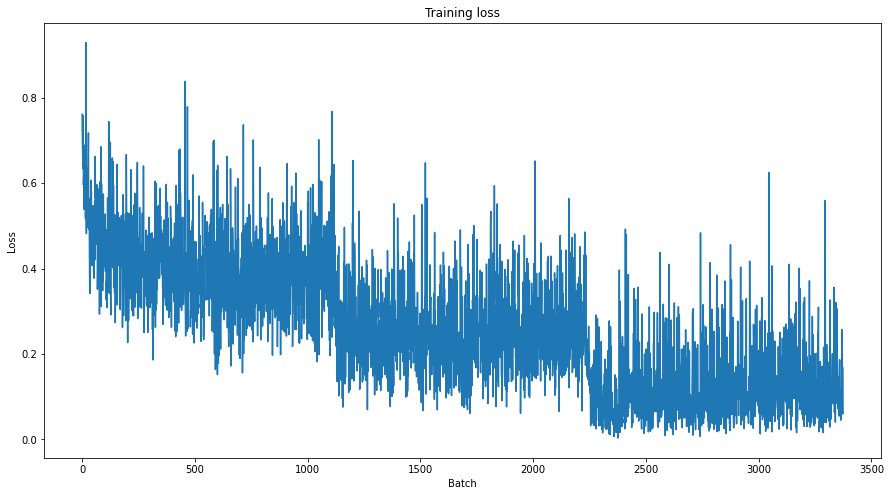

In [ ]:
# Training evaluation over batches
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [1]:
# Take a random samle of tweets to evaluate the model one (rezognize there may be some overlap)
# Print out a final accuracy number we can compare with our validation number 
df = df.sample(1000)

sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

import torch
import torch.nn.functional as F 
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = F.softmax(model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask))

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

  from sklearn.metrics import accuracy_score

final_pred = []
for num in range(len(predictions)):
  binary_pred = []
  for i in predictions[num]: 
    if i[0] > i[1]:
      binary_pred.append(0)
    else:
      binary_pred.append(1)
   
  final_pred.append(np.array(binary_pred))
  
accuracy = []
for i in range(len(final_pred)):
  accuracy.append(accuracy_score(true_labels[i], final_pred[i]))

print(sum(accuracy) / len(accuracy))


In [2]:
# Read over tweets in a certain date range, and evaluate model on it. What we care is % of positive tweets, and how that number fluctuates over time
# Paramters of the tweets are set a couple lines below
!pip install GetOldTweets3
import GetOldTweets3 as got
import numpy as np
import datetime
import time

base = datetime.datetime(2020, 3, 28 )
numdays = 30
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]

percentagepos = []
datepos = []
neg_ex = []
pos_ex = []
for date in date_list:
  tweets = 1000
  tweetCriteria = got.manager.TweetCriteria().setQuerySearch('$#AllLivesMatter-filter:retweets').setSince('2011-04-02').setUntil(date.strftime('%Y-%m-%d')).setMaxTweets(tweets)
  tweet = got.manager.TweetManager.getTweets(tweetCriteria)
  tweet_list = []
  for t in tweet:
    tweet_list.append(t.text)

  df = pd.DataFrame(tweet_list)
  df.columns = ["sentence"]

  sentences = df.sentence.values

  sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


  MAX_LEN = 128

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  attention_masks = []

  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
    
  batch_size = 32  


  prediction_data = TensorDataset(prediction_inputs, prediction_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  import torch
  import torch.nn.functional as F 
  model.eval()

  predictions = []

  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
      logits = F.softmax(model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask))

    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

    from sklearn.metrics import accuracy_score

  final_pred = []
  pos_pred = 0
  neg_pred = 0
  for num in range(len(predictions)):
    binary_pred = []
    for index,i in enumerate(predictions[num]): 
      if i[0] > i[1]:
        neg_pred+=1
      else:
        pos_pred+=1
      if i[0] > 0.95:
        neg_ex.append(sentences[num*batch_size+index])
      if i[1] > 0.95:
        pos_ex.append(sentences[num*batch_size+index])
  print(set(neg_ex))
  print(set(pos_ex))

  percentagepos.append(pos_pred / (pos_pred + neg_pred))
  datepos.append(date)
  print(date)
  time.sleep(60)
    
print(percentagepos)
print(datepos)




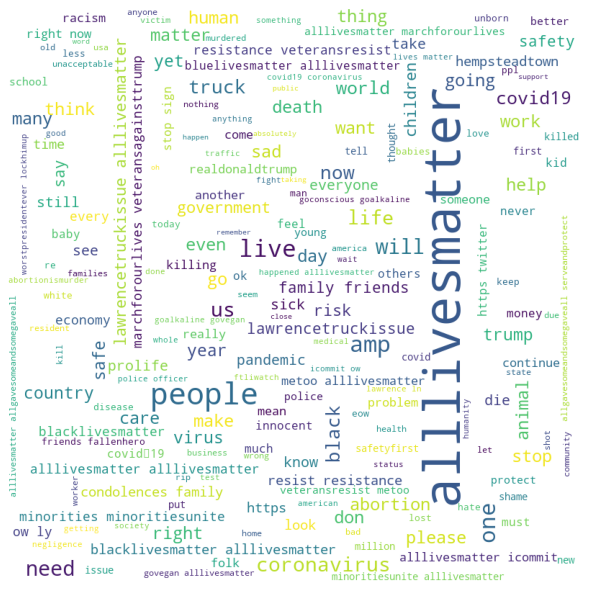

In [ ]:
#Word Cloud

# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd  

  
comment_words = '' 
stopwords = set(STOPWORDS) 
stopwords.add('SEP')
stopwords.add('CLS')
# iterate through the csv file 
for val in set(neg_ex): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
# Negative word cloud above, positive below

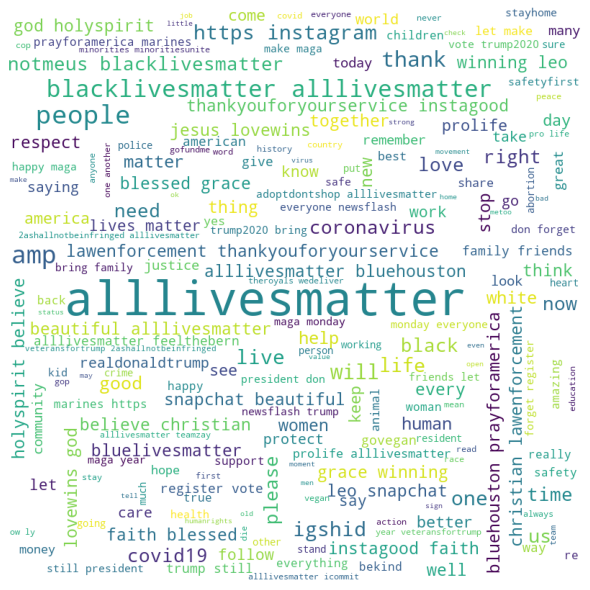

In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 
stopwords.add('SEP')
stopwords.add('CLS')
# iterate through the csv file 
for val in set(pos_ex): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 